# Simple Regression NN

In [1]:
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import  DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from testTrainData import TrainData, TestData

# Model imports
from multiLabelRegression import MultiLabelRegression
from multiLayerMultiLabelRegression import MultiLayerMultiLabelRegression


In [2]:
# Import modules from parent directory
sys.path.insert(0,'..')

from ipynb.fs.full.training_preprocessing import GetDataset

In [3]:
df = GetDataset()

In [4]:
# set x equal to all columns except for the transaction_count and workforce_type_1
x = df.drop(['transaction_count', 'workforce_type_1','workforce_type_2', 'workforce_type_3','workforce_type_4'], axis=1)
# convert x to a 2d array
x = x.values.tolist()


# set y equal to the transaction_count and workforce_type_1 columns
y = df[['transaction_count', 'workforce_type_1', 'workforce_type_2', 'workforce_type_3','workforce_type_4']]
# convert y to an array
y = y.values.tolist()

In [5]:
TEST_SIZE = 0.33

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=TEST_SIZE)

In [6]:
train_data = TrainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
x

test_data = TestData(torch.FloatTensor(X_test))

In [31]:
def train(model, scheduler, criterion, num_epochs, train_loader):
    lowest_loss = 1000

    for epoch in range(num_epochs):
        for inputs, targets in train_loader:
            # Forward pass
            outputs = model(inputs)
            # Compute loss
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            scheduler.optimizer.zero_grad()
            loss.backward()
            scheduler.optimizer.step()

        scheduler.step(loss)
        print(scheduler.optimizer.param_groups[0]['lr'])

        # check if the current model has the lowest loss
        if loss < lowest_loss:
            # update the lowest loss variable
            lowest_loss = loss
            
            # save the current model checkpoint
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': scheduler.optimizer.state_dict(),
                'loss': lowest_loss
            }
            torch.save(checkpoint, 'saved/best_modelcheckpoint.pt')
            torch.save(model.state_dict(), 'saved/best_model.pt')
            
        # Print progress
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [33]:
# Hyperparameters
LEARNING_RATE = 0.001
EPOCHS = 1000

In [34]:
# Models
model = MultiLayerMultiLabelRegression(11, 5)
#model = MultiLabelRegression(11, 5)
model.to(device)

MultiLayerMultiLabelRegression(
  (linear1): Linear(in_features=11, out_features=12, bias=True)
  (linear2): Linear(in_features=12, out_features=8, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear3): Linear(in_features=8, out_features=5, bias=True)
)

In [35]:
# Define the loss function and the optimizer
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
#optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) # step size = how many epochs to update lr after, gamma = how much to update lr by
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-10)
#optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)


In [36]:
train(model, scheduler, criterion, EPOCHS, train_data)

0.001
Epoch [1/1000], Loss: 28.3060
0.001
Epoch [2/1000], Loss: 2.4872
0.001
Epoch [3/1000], Loss: 1.0511
0.001
Epoch [4/1000], Loss: 50.9577
0.001
Epoch [5/1000], Loss: 43.9473
0.001
Epoch [6/1000], Loss: 0.7398
0.001
Epoch [7/1000], Loss: 34.3268
0.001
Epoch [8/1000], Loss: 0.4611
0.001
Epoch [9/1000], Loss: 8.3248
0.001
Epoch [10/1000], Loss: 59.9689
0.001
Epoch [11/1000], Loss: 32.2461
0.001
Epoch [12/1000], Loss: 19.1655
0.001
Epoch [13/1000], Loss: 3.8542
Epoch 00014: reducing learning rate of group 0 to 1.0000e-04.
0.0001
Epoch [14/1000], Loss: 22.1638
0.0001
Epoch [15/1000], Loss: 8.1507
0.0001
Epoch [16/1000], Loss: 4.9528
0.0001
Epoch [17/1000], Loss: 0.5291
0.0001
Epoch [18/1000], Loss: 0.9394
0.0001
Epoch [19/1000], Loss: 13.6822
Epoch 00020: reducing learning rate of group 0 to 1.0000e-05.
1e-05
Epoch [20/1000], Loss: 7.4650
1e-05
Epoch [21/1000], Loss: 15.6962
1e-05
Epoch [22/1000], Loss: 17.3953
1e-05
Epoch [23/1000], Loss: 17.4797
1e-05
Epoch [24/1000], Loss: 6.4713
1e-

In [56]:
# Save the torch model
#torch.save(model.state_dict(), 'saved/multiLayerRegression_1000epochs.pth')

# Load the best model
#model = torch.load('saved/best_modelcheckpoint.pt')
#model = torch.load('saved/best_model.pt')
model.load_state_dict(torch.load('saved/best_model.pt'))

<All keys matched successfully>

In [49]:
# Get the model loss
#model_loss = model['loss']
#model_loss

#model = model['model_state_dict']
#model = torch.load('saved/best_model.pt')


## Evaluating model performance

In [57]:
Xtest = torch.FloatTensor(X_test)
test_loader = DataLoader(dataset=Xtest, batch_size=1)

# Set the model to eval mode and generate a list of predictions for the test data
model.eval()
y_pred_list = []
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_pred_list

[[28.152206420898438,
  1.0003782510757446,
  2.663285493850708,
  3.662513256072998,
  0.5478879809379578],
 [24.97201156616211,
  1.000380039215088,
  2.5836687088012695,
  3.582698345184326,
  0.5102419853210449],
 [28.02093505859375,
  1.0004663467407227,
  2.665756940841675,
  3.6650309562683105,
  0.5426195859909058],
 [39.02755355834961,
  1.0003186464309692,
  2.935800075531006,
  3.9356517791748047,
  0.6753107309341431],
 [44.82438278198242,
  1.0004099607467651,
  3.101468801498413,
  4.101874828338623,
  0.7330641746520996],
 [39.5809440612793,
  1.0003595352172852,
  2.9603002071380615,
  3.9602677822113037,
  0.6742653250694275],
 [15.50679874420166,
  1.0005203485488892,
  2.354607582092285,
  3.353158473968506,
  0.39197081327438354],
 [26.153186798095703,
  1.0004347562789917,
  2.6218557357788086,
  3.62103009223938,
  0.5169165134429932],
 [17.859012603759766,
  1.0005176067352295,
  2.411961317062378,
  3.410651206970215,
  0.4224436283111572],
 [37.61699295043945,


In [58]:
# create an array of only the first object of each array inside y_pred_list
transaction_count_predictions = [a[0] for a in y_pred_list]
transaction_count_actuals = [a[0] for a in y_test]

In [61]:
# Calculate the MSE and MAE between the predictions and the actual values
mse = mean_squared_error(y_test, y_pred_list)
mae = mean_absolute_error(y_test, y_pred_list)

print(f'MSE: {mse:.2f}, MAE: {mae:.2f}')


MSE: 23.05, MAE: 1.67


In [63]:
# Calculate the MSE and MAE between only the transaction_count prediction and the actual values
mse = mean_squared_error(transaction_count_actuals, transaction_count_predictions)
mae = mean_absolute_error(transaction_count_actuals, transaction_count_predictions)

print(f'MSE: {mse:.2f}, MAE: {mae:.2f}')

MSE: 114.02, MAE: 6.84


In [64]:
# Calculate SMAPE between actual and predicted values.
def smape(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)
    smape_val = (100.0 / actual.size) * np.sum(2.0 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))
    return smape_val

In [70]:
smape = smape(y_pred_list, y_test)
print(smape)

TypeError: 'numpy.float64' object is not callable

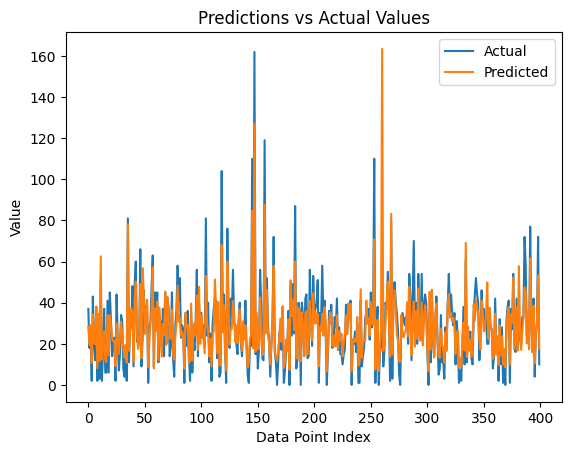

In [67]:
# Graph the predictions vs the actual values
import matplotlib.pyplot as plt

#plt.scatter(transaction_count_predictions, transaction_count_actuals, alpha=0.5)
plt.plot(transaction_count_actuals[200:600], label='Actual')
plt.plot(transaction_count_predictions[200:600], label='Predicted')
plt.xlabel('Data Point Index')
plt.ylabel('Value')
plt.title('Predictions vs Actual Values')
plt.legend()
plt.show()